In [1]:
!pip install parasol-nlp
!pip install konlpy
#!pip install tensorflow-gpu==1.15.2

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)
from parasol import Tokenizer

import numpy as np
import os
import re
import time
from collections import Counter

2.2.0


# Prepare data

### Read data

In [3]:
with open("small", "r") as f:
  text = f.read()

text = re.sub(r"\([^\)]+\)", "", text).strip()
text = '\n'.join([ t for t in text.split('\n') if re.search(r'[一-龯ぁ-んァ-ン]+', t)==None])
print("Text Sample >>\n{}\n".format(text[:200]))
print("Length >>\n{}".format(len(text)))

Text Sample >>
T-50 골든이글
KAI T-50 골든이글()은 대한민국이 제작한 초음속 고등 훈련기이다. 2005년 10월부터 제작사인 한국항공우주산업에서 양산에 들어가, 2005년 12월에 1호기가 납품되었다. 2008년 3월 25일 초도분량 25대 도입이 모두 완료되어 기존의 T-38 탤론의 역할을 대체하였다. 현재 납품된 기체는 대한민국 공군 1 전투비행단소속 18

Length >>
7641228


### Preprocess text data

Load data and tokenize. Convert to id

In [4]:
def encode_data(text, tokenize, vocab_size=None):

  tokens = []
  for line in text.split("\n"):
    if len(line.strip())==0: continue;
    tokens.extend(tokenize(line))
  print("Tokenization done.")

  c = Counter(tokens)
  if vocab_size:
    vocabs = ['UNK'] + [ word for word, cnt in c.most_common(vocab_size - 1) ]
  else:
    vocabs = [ word for word, cnt in c.most_common() ]
    vocab_size = len(vocabs)

  print(f"Total number of tokens: {len(tokens)}. Vocab size: {vocab_size}")
  word2id = { word: idx for idx, word in enumerate(vocabs)}
  text_encoded = np.array([word2id.get(t,0) for t in tokens])

  return text_encoded, vocab_size

### Make tensorflow dataset

Make language model data(input, target) and convert to tensorflow batch data

In [5]:
# 임베딩 차원
embedding_dim = 64

# RNN 유닛(unit) 개수
rnn_units = 256

batch_size = 64

buffer_size = 1000

seq_length = 100

In [6]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

def batch_dataset(text_encoded):
  token_dataset = tf.data.Dataset.from_tensor_slices(text_encoded)
  sequences = token_dataset.batch(seq_length+1, drop_remainder=True)
  dataset = sequences.map(split_input_target)
  dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
  dataset = dataset.repeat()
  return dataset

# Language model neural network

### Define model

In [7]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=False,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

### Train

Log perplexity

In [8]:
from collections import defaultdict

class LossCallback(tf.keras.callbacks.Callback):
  def __init__(self, name, log_dict):
    super(LossCallback, self).__init__()
    self.name = name
    self.writer = None
    self.log_dict = log_dict

  def on_train_batch_end(self, batch, logs=None):
    if self.writer is None:
      self.writer = open(f"{self.name}.log", "w")
    
    self.writer.write("{}\t{:.4f}\n".format(batch, logs["loss"]))
    self.log_dict[self.name].append((batch, logs["loss"]))

  def on_train_end(self, logs=None):
    self.writer.close()

In [9]:
def run_experiment(text, tokenize, name, log_dict):
  text_encoded, vocab_size = encode_data(text, tokenize, 30000)
  dataset = batch_dataset(text_encoded)

  model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
  model.compile(optimizer='sgd', loss="sparse_categorical_crossentropy")
  
  examples_per_epoch = len(text_encoded)//seq_length
  steps_per_epoch = examples_per_epoch // batch_size

  logger = LossCallback(name, log_dict)
  model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, callbacks=[logger])

In [10]:
log = defaultdict(list)

t1 = Tokenizer(decompose=True)
tokenize = lambda x:t1.tokenize(x, as_id=True)
run_experiment(text, tokenize, "bpe_with_decomposition", log)

t2 = Tokenizer(decompose=False)
tokenize = lambda x:t2.tokenize(x, as_id=True)
run_experiment(text, tokenize, "bpe_no_decomposition", log)

from konlpy.tag import Komoran
k = Komoran()
def tokenize(text):
  poses = k.pos(text)
  return [ a for a,b in poses ]
run_experiment(text, tokenize, "morph_analyzer_komoran", log)

Tokenization done.
Total number of tokens: 3733642. Vocab size: 30000
Epoch 1/10
583/583 [==============================] - 64s 109ms/step - loss: 10.4075
Epoch 2/10
583/583 [==============================] - 63s 109ms/step - loss: 9.8643
Epoch 3/10
583/583 [==============================] - 63s 109ms/step - loss: 9.7604
Epoch 4/10
583/583 [==============================] - 63s 109ms/step - loss: 9.6876
Epoch 5/10
583/583 [==============================] - 64s 109ms/step - loss: 9.6050
Epoch 6/10
583/583 [==============================] - 63s 109ms/step - loss: 9.5466
Epoch 7/10
583/583 [==============================] - 63s 109ms/step - loss: 9.5172
Epoch 8/10
583/583 [==============================] - 64s 109ms/step - loss: 9.4981
Epoch 9/10
583/583 [==============================] - 63s 109ms/step - loss: 9.4789
Epoch 10/10
583/583 [==============================] - 64s 109ms/step - loss: 9.4477
Tokenization done.
Total number of tokens: 3568991. Vocab size: 30000
Epoch 1/10
557/557

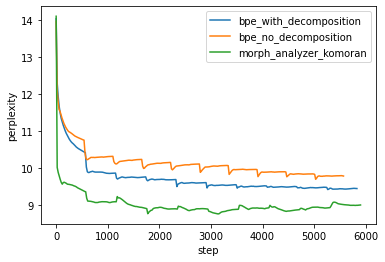

In [11]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

def get_smooth(data):
  step = np.arange(len(data))
  loss = data[:,1]
  xnew = np.linspace(step.min(), step.max(), 300)  
  spl = make_interp_spline(step, loss, k=3)  # type: BSpline
  smooth = spl(xnew)
  return xnew, smooth
  
for name, data in log.items():
  data = np.array(data)
  x, y = get_smooth(data)
  plt.plot(x, y, label=name)

plt.xlabel("step")
plt.ylabel("perplexity")
plt.legend()
plt.show()